# Convolutional Neural Networks: Application

Welcome to Course 4's second assignment! In this notebook, you will:

- Implement a fully functioning ConvNet using PyTorch 

**After this assignment you will be able to:**

- Build and train a ConvNet in PyTorch for a classification problem 

## 1.0 - PyTorch model

In the previous assignment, you built helper functions using numpy to understand the mechanics behind convolutional neural networks. Most practical applications of deep learning today are built using programming frameworks, which have many built-in functions you can simply call. 

As usual, we will start by loading in the packages. 

In [27]:
from cnn_utils import *
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy
import PIL
from scipy import ndimage


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2

%matplotlib inline
np.random.seed(1)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Run the next cell to load the "SIGNS" dataset you are going to use.

In [3]:
#Loading the data (signs)
train_dataset, test_dataset, train_loader, test_loader, classes = get_data()

As a reminder, the SIGNS dataset is a collection of 6 signs representing numbers from 0 to 5.

<img src="images/SIGNS.png" style="width:800px;height:300px;">

The next cell will show you an example of a labelled image in the dataset. Feel free to change the value of `index` below and re-run to see different examples. 

y = 2


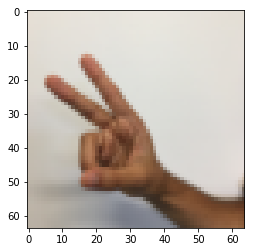

In [4]:
#Example of a picture
index = 6
img = train_dataset[index][0].numpy().transpose([1, 2, 0])
plt.imshow(img)
print ("y =", str(np.squeeze(train_dataset[index][1].numpy())))

In Course 2, you had built a fully-connected network for this dataset. But since this is an image dataset, it is more natural to apply a ConvNet to it.

To get started, let's examine the shapes of your data. 

In [5]:
print ("number of training examples =", len(train_dataset))
print ("number of test examples =", len(test_dataset))
print ("shape of a batch of train dataset examples:", next(iter(train_loader))[0].shape)
print ("shape of a batch of train dataset labels:", next(iter(train_loader))[1].shape)

number of training examples = 1080
number of test examples = 120
shape of a batch of train dataset examples: torch.Size([64, 3, 64, 64])
shape of a batch of train dataset labels: torch.Size([64, 1])


## Model

In [6]:
#Define Flatten layer
class Flatten(nn.Module):
    def forward(self, x):
        N, C, H, W = x.size()
        return x.view(N, -1)

In [7]:
#Define our model
model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    Flatten(),
    nn.Linear(2048, 6)
).to(device)

In [8]:
#Set up loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

## Train

In [9]:
def get_accuracy(model, loader):
    model.eval()
    num_samples = 0
    num_correct = 0
    with torch.no_grad():
        for i, (x, y) in enumerate(loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            _, preds = y_pred.data.max(1)
            num_samples += preds.size(0)
            num_correct += (y.view(-1) == preds).sum()
        
    return num_correct.item() / num_samples
        

In [10]:
def train(model, test_loader, train_loader, epochs = 100, print_every=10):
    model.train()
    #costs = []
    for e in range(1, epochs+1):
        if e % print_every == 0:
            print('Epoch', e, '| Test Accuracy:', get_accuracy(model, test_loader), '| Train Accuracy:', get_accuracy(model, train_loader))
        for i, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            y_pred = model(x)
            loss = loss_fn(y_pred, y.view(-1))
            #costs.append(loss.data[0])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [36]:
train(model, test_loader, train_loader, epochs=100)

Epoch 10 | Test Accuracy: 0.8333333333333334 | Train Accuracy: 0.8814814814814815
Epoch 20 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.9074074074074074
Epoch 30 | Test Accuracy: 0.8666666666666667 | Train Accuracy: 0.9064814814814814
Epoch 40 | Test Accuracy: 0.875 | Train Accuracy: 0.912962962962963
Epoch 50 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.9231481481481482
Epoch 60 | Test Accuracy: 0.8333333333333334 | Train Accuracy: 0.9101851851851852
Epoch 70 | Test Accuracy: 0.8583333333333333 | Train Accuracy: 0.9333333333333333
Epoch 80 | Test Accuracy: 0.8416666666666667 | Train Accuracy: 0.9342592592592592
Epoch 90 | Test Accuracy: 0.8583333333333333 | Train Accuracy: 0.937962962962963
Epoch 100 | Test Accuracy: 0.8833333333333333 | Train Accuracy: 0.9444444444444444


In [12]:
get_accuracy(model, test_loader)

0.825

## Test

tensor(5, device='cuda:0')


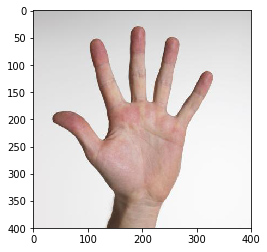

In [35]:
im_path = "images/5.jpg"
plt.imshow(plt.imread(im_path))

inp = path_to_input(im_path, 64, device)
y_pred = model(inp)
_, y_pred_cls = y_pred.data.max(1)
print(y_pred_cls[0])